In [1]:
import json
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from pprint import pprint

In [2]:
# load the reviews data
with open("../data/raw/Video_Games.json", 'rb') as f:
    data = f.readlines()
    data = [json.loads(line) for line in data]

reviews_df = pd.DataFrame(data)
print(f"The dataframe consists of {reviews_df.shape[0]} rows and {reviews_df.shape[1]} columns")
print(f"The number of unique users: {reviews_df['reviewerID'].nunique()}")

reviews_df.head()

The dataframe consists of 2565349 rows and 12 columns
The number of unique users: 1540618


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"06 9, 2014",A21ROB4YDOZA5P,0439381673,Mary M. Clark,I used to play this game years ago and loved i...,Did not like this,1402272000,NaN,NaN,NaN
1,3.0,True,"05 10, 2014",A3TNZ2Q5E7HTHD,0439381673,Sarabatya,The game itself worked great but the story lin...,Almost Perfect,1399680000,NaN,NaN,NaN
2,4.0,True,"02 7, 2014",A1OKRM3QFEATQO,0439381673,Amazon Customer,I had to learn the hard way after ordering thi...,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,1391731200,15,NaN,NaN
3,1.0,True,"02 7, 2014",A2XO1JFCNEYV3T,0439381673,ColoradoPartyof5,The product description should state this clea...,does not work on Mac OSX,1391731200,11,NaN,NaN
4,4.0,True,"01 16, 2014",A19WLPIRHD15TH,0439381673,Karen Robinson,I would recommend this learning game for anyon...,Roughing it,1389830400,NaN,NaN,NaN


In [3]:
# check and compare how many unique `reviewText` are there
print(f"The number of unique product reviews: {reviews_df['reviewText'].nunique()}")
# check on the duplicated reviews
print(reviews_df['reviewText'].value_counts().sort_values())
# we observe that some reviews are short let's set the threshold of reviews text > 50 characters.
reviews_df.dropna(axis=0, subset=['reviewText'], inplace=True)
reviews_df = reviews_df[reviews_df['reviewText'].map(len) > 50]
# check on the duplicated reviews
print(reviews_df['reviewText'].value_counts().sort_values())    
      
# summary statistics
print(f"The number of unique users: {reviews_df['reviewerID'].nunique()}")

The number of unique product reviews: 2196727
Hands down one of the most well crafted, all around outstanding game of this generation. I could write a huge review but I really would rather keep playing. I bought the last of us on release day last year for ps3 and was absolutely blown away. Ive never played a game that gave me tears so many times before. Now the remastered comes out and its like reliving it all over again. Truly astounding acting, story, gameplay and visuals. Naughty dog has found their true calling. If you haven't played this, you really need to. Its an experience I never thought I could get from a videogame.                                                                                                                                                                                                                                                                                                                                                                               

Shipped quick, works great. Much rather charge the controllers this way then attaching them via usb. So convenient. Definitely recommend buying one.                                                                                                                                                                                                                                                                                                                                1
Amazing game!!!!! Made me put down my Nintendo switch!                                                                                                                                                                                                                                                                                                                                                                                                                              1
I have been a Logitech mouse fan for a while, but when my 51

In [4]:
# checking rows similar values
dup_review_samp = reviews_df[reviews_df['reviewText'] == 'this product came in on time if not earlier. item was descibed exactly as it was in the description. thanks.']

# let arrange by asin, and see if reviews is still the same
dup_review_samp.sort_values(by=['asin'])

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
2166653,5.0,True,"12 29, 2012",A275FA60H04HOP,B000009QCY,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
7158,5.0,True,"12 29, 2012",A275FA60H04HOP,B00000I1BJ,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
30835,5.0,True,"12 29, 2012",A275FA60H04HOP,B00002STKG,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
28156,5.0,True,"12 29, 2012",A275FA60H04HOP,B00002STKH,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
28847,5.0,True,"12 29, 2012",A275FA60H04HOP,B00002STOX,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
30932,5.0,True,"12 29, 2012",A275FA60H04HOP,B00002STPL,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
31441,5.0,True,"12 29, 2012",A275FA60H04HOP,B00002STPM,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
40806,5.0,True,"12 29, 2012",A275FA60H04HOP,B000038AAN,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
58250,5.0,True,"12 29, 2012",A275FA60H04HOP,B00004U5VK,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN
73445,5.0,True,"12 29, 2012",A275FA60H04HOP,B000059Z8I,Chu,this product came in on time if not earlier. i...,great,1356739200,NaN,NaN,NaN


We identified that there are users like `A2PSEMWT9TR272` who duplicates the same review over and over again across different products, while at times the same product have an duplicated review as well. Hence, there is a possibility users that are doing similiar things, which we will have to remove them.

In [5]:
# our approach is to count the values of (user, reviews) > 1
reviews_user_date_text = reviews_df[['reviewerID', 'reviewText']]
# marking all duplicates except first one as True
reviews_user_date_text = reviews_user_date_text[reviews_user_date_text.duplicated()].sort_values('reviewText')
# finding users with more than 1 time of duplications
dup_user_reviews = reviews_user_date_text[['reviewerID', 'reviewText']].value_counts().to_frame()

# to qualify a users as a potential bot or repeated spam users -> same user and review > 1 (means in technicality they posted the same thing thrice)
dup_user_reviews = dup_user_reviews[dup_user_reviews.iloc[:,0] > 2]
# getting the unique users who have potential as bots
# potential_bot_users = dup_user_reviw
potential_bot_users = dup_user_reviews.reset_index()['reviewerID'].unique().tolist()

# summary
print(f"The number of potential bot users is {len(potential_bot_users)}.")

The number of potential bot users is 1462.


In [6]:
# using the potential bot users list, we can filter out all reviews by them
reviews_df = reviews_df[~reviews_df['reviewerID'].isin(potential_bot_users)]

print(f"The dataframe consists of {reviews_df.shape[0]} rows and {reviews_df.shape[1]} columns")

The dataframe consists of 1935485 rows and 12 columns


In [7]:
# check on the duplicated reviews
print(reviews_df['reviewText'].value_counts().sort_values())    
      
# summary statistics
print(f"The number of unique users: {reviews_df['reviewerID'].nunique()}")

Kinect Sports: Season 2 takes six well loved sports and simplifies them so that all ages can enjoy playing. Motion controls are improved, easy pick-up-and-play game modes for all ages. Various difficulty levels push you to play better. Four stars easy.                                                                                                                                                                                                                                                                                                                                                        1
It's a must buy for those without too much space in the living room like me.\nNicely finished, flexible and resistant, it was pretty easy to assemble and rotate it.\nThe detail of the lens cover is an extra and the whole kit fits my tv as if it's an original accessory.\nTotally worth it!                                                                                                                  

In [8]:
filtered_reviews_count = reviews_df['reviewText'].value_counts().sort_values().to_frame()

# number of reviews > 2 
duplicated_reviews = len(filtered_reviews_count[filtered_reviews_count['reviewText'] >= 2])

# summary statistics
# we want to see how many % of the total reviews is still duplicated 
# this allows us to better determined if we need to effectively increase the threshold
print(f"The total number of reviews: {len(reviews_df)}, % of duplicated reviews {((duplicated_reviews / len(reviews_df)) * 100):.2f}%")

The total number of reviews: 1935485, % of duplicated reviews 4.04%


In [9]:
# saving interim reviews to seperate csv
reviews_df.to_csv("../data/interim/reviews.csv")

In [10]:
# loading the metadata
with open("../data/raw/meta_Video_Games.json", 'rb') as f:
    data = f.readlines()
    data = [json.loads(line) for line in data]

metadata_df = pd.DataFrame(data)
print(f"The dataframe consists of {metadata_df.shape[0]} rows and {metadata_df.shape[1]} columns.")

# check and compare how many unique asin are there
print(f"The number of unique product ids: {metadata_df['asin'].nunique()}")
# dropping duplicates of asin -> as metadata should not be duplicated
metadata_df.drop_duplicates(subset=['asin'], keep='last', inplace=True, ignore_index=True)
print(f"The dataframe consists of {metadata_df.shape[0]} rows and {metadata_df.shape[1]} columns.")

metadata_df.head()

The dataframe consists of 84819 rows and 19 columns.
The number of unique product ids: 71911
The dataframe consists of 71911 rows and 19 columns.


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [11]:
# saving interim metadata to seperate csv
metadata_df.to_csv("../data/interim/metadata.csv")

### 1. Exploratory Data Analysis

In [12]:
# merging metadata and reviews to get more information
overall_df = pd.merge(metadata_df, reviews_df, how='inner', on='asin')
overall_df.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,...,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",...,True,"03 11, 2015",A285UYK35TF093,Stefano,Simply extraordinary! A jump into my past and ...,Top of the top Reversi Machine,1426032000,NaN,NaN,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...",...,True,"08 24, 2013",A24SSUT5CSW8BH,Kindle Customer,I want to start off by saying I have never pla...,Love the game,1377302400,NaN,NaN,NaN
2,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...",...,True,"07 7, 2013",AB9S9279OZ3QO,Alan,I haven't gotten around to playing the campaig...,Good game and Beta access!!,1373155200,2,NaN,NaN
3,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...",...,False,"07 4, 2013",AK3V0HEBJMQ7J,Royalty,this will be my second medal of honor I love h...,MOH nice,1372896000,NaN,NaN,NaN
4,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",...,True,"09 11, 2015",A24KMZPZDZ5T3,NEW GAME+,"Ordered an arcade stick, received a business l...",One Star,1441929600,NaN,NaN,NaN


In [13]:
# let just keep the columns we required
reviews_subset_df = overall_df.loc[:, ['title', 'asin', 'brand', 'rank', 'verified', 'overall', 'reviewerID', 'reviewText']]

# summary statistics
print(f"The dataframe consists of {reviews_subset_df.shape[0]} rows and {reviews_subset_df.shape[1]} columns.")
reviews_subset_df.head()

The dataframe consists of 1932240 rows and 8 columns.


,title,asin,brand,rank,verified,overall,reviewerID,reviewText
0,Reversi Sensory Challenger,0042000742,Fidelity Electronics,"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",True,5.0,A285UYK35TF093,Simply extraordinary! A jump into my past and ...
1,Medal of Honor: Warfighter - Includes Battlefi...,0078764343,by\n \n EA Games,"[>#67,231 in Video Games (See Top 100 in Video...",True,5.0,A24SSUT5CSW8BH,I want to start off by saying I have never pla...
2,Medal of Honor: Warfighter - Includes Battlefi...,0078764343,by\n \n EA Games,"[>#67,231 in Video Games (See Top 100 in Video...",True,5.0,AB9S9279OZ3QO,I haven't gotten around to playing the campaig...
3,Medal of Honor: Warfighter - Includes Battlefi...,0078764343,by\n \n EA Games,"[>#67,231 in Video Games (See Top 100 in Video...",False,4.0,AK3V0HEBJMQ7J,this will be my second medal of honor I love h...
4,Xbox 360 MAS STICK,0324411812,by\n \n MAS SYSTEMS,"[>#105,263 in Video Games (See Top 100 in Vide...",True,1.0,A24KMZPZDZ5T3,"Ordered an arcade stick, received a business l..."


In [14]:
# saving this subset data into an interim csv
reviews_subset_df.to_csv("../data/interim/reviews_merged.csv")

#### 1.1 What is the mean rating across all available products?

In [15]:
# if we were to calculate ratings -> let's take the 'verifed ratings only'
verified_reviews = reviews_subset_df[reviews_subset_df['verified']]

verified_reviews['overall'].mean()

3.9462127904983775

#### 1.2 What is the statistics on reviews?

##### 1.2.1 Most reviewed product

In [16]:
prod_reviews = verified_reviews.groupby(['asin']).agg({'reviewText': 'count'}).sort_values(by='reviewText', ascending=False)

# what is the highest number of reviews for a product 
print(f"The highest number of reviews for a product: product is {prod_reviews.index[0]} with {prod_reviews.max()[0]} reviews.")
# let's see what is it mean rating?
print(f"The mean rating for {prod_reviews.index[0]} is "
      f"{verified_reviews[verified_reviews['asin'] == prod_reviews.index[0]]['overall'].mean():.2f}")

# let see the product
verified_reviews[verified_reviews['asin'] == prod_reviews.index[0]]

The highest number of reviews for a product: product is B00HTK1NCS with 4508 reviews.
The mean rating for B00HTK1NCS is 4.10


,title,asin,brand,rank,verified,overall,reviewerID,reviewText
1419931,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,5.0,A1YBOY0EY7VACJ,Amazing mouse it glows making it even cooler b...
1419932,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,5.0,AG543ZHSNBNL4,Nice mouse! I play wow and is perfect for pri...
1419933,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,5.0,A6MUO10M3IOTA,This mouse is just plain awesome for gaming at...
1419934,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,5.0,AFBPKSYXWH5O6,I bought another RedDragon mouse before but my...
1419935,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,5.0,ABX0NDNTVPF8U,It would buy this mouse again if they made it ...
...,...,...,...,...,...,...,...,...
1424919,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,3.0,A2C4YXP64SJSDR,This isn't a bad mouse for the price. I will s...
1424920,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,2.0,A2WMBBJQLH71XK,It's broken already. The left click button is ...
1424921,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,3.0,A28B27PJJRHYNT,"Honestly, I had this for about two months now...."
1424922,"Redragon M601 Wired Gaming Mouse, Ergonomic, P...",B00HTK1NCS,Redragon,[>#19 in Video Games > PC Games > PC Game Hard...,True,4.0,A2ZK4JXUO3TXQ7,This mouse was in use for about 3 years before...


##### 1.2.2 Least reviewed product

In [17]:
# what is the highest number of reviews for a product 
print(f"The highest number of reviews for a product: product is {prod_reviews.index[-1]} with {prod_reviews.min()[0]} reviews.")
# let's see what is it mean rating?
print(f"The mean rating for {prod_reviews.index[-1]} is "
      f"{verified_reviews[verified_reviews['asin'] == prod_reviews.index[-1]]['overall'].mean():.2f}")

# let see the product
verified_reviews[verified_reviews['asin'] == prod_reviews.index[-1]]

The highest number of reviews for a product: product is B004NDTRJA with 1 reviews.
The mean rating for B004NDTRJA is 1.00


,title,asin,brand,rank,verified,overall,reviewerID,reviewText
908563,Jessica Mystery of Courchevel,B004NDTRJA,Game Factory,"[>#154,176 in Video Games (See Top 100 in Vide...",True,1.0,A3B70HC6Y6CUIF,Do not buy this game. This game would not load...


You can observed that solely basing a product on ratings is not a fair game. Considering that a product like `B00178630A` which has been reviewed 7273 times, while `B00410JBDW` has only 1 review and yet its "average" rating is higher. We will need to devise some kind of weighted ratings before implementing an baseline collaborative filtering recommender.

##### 1.2.3 What is the quantile of reviews?

In [18]:
# we want to know what is mean per reviews, median, 25% and 75%
# this helps us to develop a weighted ratings subsequently

print(f"The mean number of reviews per product is: {prod_reviews.mean()[0]:.0f}")
print(f"The median number of reviews per product is: {prod_reviews.quantile(.5)[0]:.0f}")
print(f"The 25th and 75th percentile of number of reviews is: "
      f"{prod_reviews.quantile(.25)[0]:.0f} and "
      f"{prod_reviews.quantile(.75)[0]:.0f} respectively.")

The mean number of reviews per product is: 23
The median number of reviews per product is: 3
The 25th and 75th percentile of number of reviews is: 1 and 12 respectively.


We can consider setting penalizing existing mean ratings of product if they do not have at least `.8` quantile of the number of reviews. This ensures that prodcuts who are adequately purchased and reviews provides a more reliable product trust for the customers due to other consumer purchases.

In [19]:
prod_ratings = verified_reviews.groupby(['asin']).agg({'overall': np.mean})
# merging both count ratings and mean ratings
prod_overall = pd.merge(prod_reviews, prod_ratings, how='inner', left_index=True, right_index=True)
# rename the columns
prod_overall.columns = ['ratings_count', 'ratings_average']

prod_overall

,ratings_count,ratings_average
asin,,
B00HTK1NCS,4508,4.096495
B00JJNQG98,3070,4.184039
B00KKAQYXM,2957,3.747379
B000B9RI14,2729,4.617442
B00E4MQODC,2628,4.136606
...,...,...
B005842A9W,1,4.000000
B005801M3Q,1,5.000000
B0057YQV0C,1,5.000000


##### 1.2.4 Computing the weighted ratings

In [20]:
m = prod_overall['ratings_count'].quantile(.8)
C = prod_overall['ratings_average'].mean()

prod_overall['ratings_weighted'] = (prod_overall
                                    .apply(lambda x: ((x['ratings_count']/(x['ratings_count'] + m) * x['ratings_average']) 
                                                      + (m/(m + x['ratings_count']) * C)), axis=1))

prod_overall.sort_values(by='ratings_weighted', ascending=False, inplace=True)
# retrieving the product title for better understanding
prod_overall = (prod_overall
                .merge(reviews_subset_df[['title', 'asin']]
                       .drop_duplicates()
                       .set_index('asin'), 
                       how='inner', 
                       left_index=True, 
                       right_index=True)
                .reset_index())


prod_overall.head(10)

,asin,ratings_count,ratings_average,ratings_weighted,title
0,B00104UBY0,449,5.000000,4.953585,"Mamas &amp; Papas Soft Toy, Peanut Elephant"
1,B005C1B3C6,198,4.994949,4.894748,3C PRO 16GB 16G Class 10 C10 microSD microSDHC...
2,B000B6OR4I,119,4.957983,4.804197,"Cyclops CYC-80RH 1 LED Utility Bore Light, Black"
3,B01GKHJPG6,228,4.864035,4.785187,Persona 5 - SteelBook Edition - PlayStation 4
4,B00UG63VDG,796,4.772613,4.750764,TAKECASE New 3DS XL and 2DS XL Carrying Case -...
5,B0050SZ1JW,170,4.852941,4.750646,StarCraft II: Heart of the Swarm -Collector's ...
6,B001JKTC9A,504,4.783730,4.749272,Uncharted 2: Among Thieves - Playstation 3
7,B0058JADMS,76,4.973684,4.745923,Sony Playstation Network Card - $10 [Online Ga...
8,B00AKIPBNS,650,4.770769,4.744184,Fire Emblem: Awakening
9,B00XMM6L8S,231,4.813853,4.739398,Technoskin - All In One Travel Carrying Case f...


In [21]:
# looking at the bottom 10 rated items
prod_overall.tail(10)

,asin,ratings_count,ratings_average,ratings_weighted,title
60181,B019RLL6RS,50,1.580000,2.124937,SUNKY - Xbox One LED USB Dual Controller Charg...
60182,B00ZQD7VNK,220,1.977273,2.102830,No Man's Sky - PS4 [Digital Code]
60183,B00452VGZW,130,1.869231,2.084155,Command &amp; Conquer 4: Tiberian Twilight [Do...
60184,B01HD1B64C,38,1.342105,2.079469,Road Rage - PlayStation 4
60185,B00LPBD2WG,27,1.037037,2.076609,Scrabble Classic [Download]
60186,B0016P7LY6,79,1.683544,2.045529,PlayStation 3 FrontMan Wireless Guitar - White
60187,B00H9UFF68,252,1.920635,2.034836,Xbox One Controller Rechargeable Battery Pack ...
60188,B006ZNGSFW,56,1.517857,2.032477,Hoyle Card Games [Download]
60189,B01AS5GUAK,58,1.482759,1.991611,Hoyle Official Card Games (for Windows) [Downl...
60190,B01CREKLC8,100,1.440000,1.772400,SpinZ PS4 - Playstation 4 Earbuds/Headset w/Mi...


#### 1.3 What is the statistics on ratings?

##### 1.3.1 What is the quantile of ratings?

##### `Ratings Weighted`

In [22]:
# we want to know what is mean per reviews, median, 25% and 75%
# this helps us to develop a weighted ratings subsequently

print(f"The mean ratings per product is: {prod_overall['ratings_weighted'].mean():.2f}")
print(f"The median ratings per product is: {prod_overall['ratings_weighted'].quantile(.5):.2f}")
print(f"The 25th and 75th percentile of number of reviews is: "
      f"{prod_overall['ratings_weighted'].quantile(.25):.2f} and "
      f"{prod_overall['ratings_weighted'].quantile(.75):.2f} respectively.")

The mean ratings per product is: 3.76
The median ratings per product is: 3.77
The 25th and 75th percentile of number of reviews is: 3.63 and 3.86 respectively.


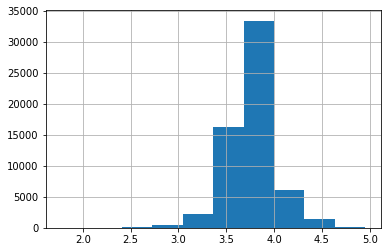

In [23]:
prod_overall['ratings_weighted'].hist()
plt.show()

`Ratings Average`

In [24]:
print(f"The mean ratings per product is: {prod_overall['ratings_average'].mean():.2f}")
print(f"The median ratings per product is: {prod_overall['ratings_average'].quantile(.5):.2f}")
print(f"The 25th and 75th percentile of number of reviews is: "
      f"{prod_overall['ratings_average'].quantile(.25):.2f} and "
      f"{prod_overall['ratings_average'].quantile(.75):.2f} respectively.")

The mean ratings per product is: 3.73
The median ratings per product is: 4.00
The 25th and 75th percentile of number of reviews is: 3.00 and 4.60 respectively.


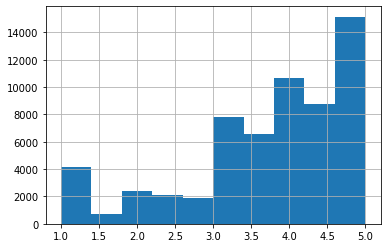

In [25]:
prod_overall['ratings_average'].hist()
plt.show()

`ratings_weighted` seems to be a normal distributions which may be more reflective. Will need figure investigation if ratings on a e-commerce tends to form a gaussian distribution after taking into account of potentials rating skewers through inflation by `bot users`, `unverified purchases`.